# Test MCS and Examples

This is a notebook for testing MCS and show examples for MCS

## import everything

modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch and other standard modules

In [2]:
%matplotlib inline
import random
import torch
from torch.utils import data
from d2l import torch as d2l

imort MCS and CostFunc

In [3]:
import MCS
import CostFunc
from MCS import MCS_optimizer
from CostFunc import SNNCostFuncL2
from CostFunc import StandardSNN

## Linear Regression

### Genrate training data

In [4]:
def synthetic_data(w, b, num_examples):  
    """y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.3446, 1.2628]) 
label: tensor([2.5951])


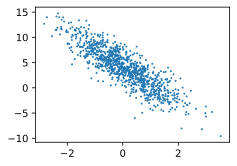

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### Reading the data via torch API

In [8]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Generate a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [9]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [10]:
next(iter(data_iter))

[tensor([[-1.2247,  1.3872],
         [-2.2720, -1.2415],
         [-0.5699, -0.0191],
         [ 1.6345,  0.1212],
         [ 1.8320,  1.1323],
         [ 1.0658, -0.7303],
         [ 0.1309,  0.2609],
         [-1.8730,  0.8901],
         [ 0.5236,  1.0503],
         [ 0.1907,  1.7811]]),
 tensor([[-2.9662],
         [ 3.8831],
         [ 3.1270],
         [ 7.0675],
         [ 4.0108],
         [ 8.8280],
         [ 3.5584],
         [-2.5764],
         [ 1.6712],
         [-1.4868]])]

## Define a model

### function for initialize weight function

In [11]:
def getParams(inputSize,numHiddens):
    w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return (w,b)

### Linear Net Model

In [12]:
class LinearNet(StandardSNN):
    '''a standard net with linear regression'''
    def __init__(self,getParams,inputSize,numHiddens):
        self.params=getParams(inputSize,numHiddens)

    def __call__(self,X:torch.Tensor):
        return self.call_with_weight(X,self.params)

    def call_with_weight(self,X:torch.Tensor,weight:tuple):
        w,b=weight
        return torch.matmul(X,w)+b

In [13]:
net=LinearNet(getParams,2,1)

### Loss function

In [14]:
lossFunc=SNNCostFuncL2(net)

E:\anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### MCS optimizer

In [15]:
net=LinearNet(getParams,2,1)
mcs=MCS_optimizer(net.params,lossFunc,data_iter,\
                    maxLevyStepSize=0.1,\
                    nestNum=6)

In [16]:
num_epochs=3
for epoch in range(num_epochs):
    mcs.step()
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 3.201226
epoch 2, loss 0.356508
epoch 3, loss 0.002870


In [17]:
w,b=net.params
print(w,b)
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

tensor([[ 1.9503],
        [-3.4142]], requires_grad=True) tensor([4.2106], requires_grad=True)
w的估计误差: tensor([0.0497, 0.0142], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0106], grad_fn=<RsubBackward1>)


### standard sgd

In [26]:
net=LinearNet(getParams,2,1)

In [27]:
def squared_loss(y_hat, y):  #@save
    """L2 loss"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [28]:
def sgd(params, lr, batch_size):  
    """sgd"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [29]:
lr = 0.03
num_epochs = 3
loss = squared_loss

In [30]:
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = lossFunc(net(X), y)
        l.sum().backward()
        sgd(net.params, lr, batch_size) 
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000447
epoch 2, loss 0.000104
epoch 3, loss 0.000105


In [31]:
w,b=net.params
print(w,b)
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

tensor([[ 2.0006],
        [-3.3999]], requires_grad=True) tensor([4.1999], requires_grad=True)
w的估计误差: tensor([-0.0006, -0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)
